# Lista de exercícios sobre TensorFlow - Gradiente Descendente

**Disciplina**: Introdução a redes neurais profundas 2018/1  
**Professor**: Jorge Leonid Aching Samatelo

**Aluno**: Humberto da Silva Neto

## Indicações <a name="indicacoes"></a>

### Considerações
* Cada aluno enviará por e-mail a solução dos exercícios propostos, tais soluções devem ser inseridas neste mesmo arquivo. 
* Para saber cómo trabalhar com arquivos `*.ipynb` é necessario ler os slides `003_JUPYTER_2x2.pdf`.
* Usar o interprete de `python 3.5`.

### Prazo
* Envio das soluções: Domingo 3/06/2018 - (23:59 pm) 

### Procedimento para o envio das soluções
* O arquivo `*.ipynb` com as soluções dos exercícios deve ser enviado ao email <jlasam001@gmail.com> com o assunto: LISTA_EXERCICIO_GSD_2018_1. 
* O nome do arquivo `*.ipynb` deve iniciar com o rotulo LISTA_GSD seguido pelas iniciais do nome do aluno que soluciono os exercícios (por exemplo, o aluno Pedro Farias enviara o arquivo LISTA_GSD_PF).

### Dicas execução
* Carregue todos os pacotes que serão necessários no início do arquivo
* Entre um exercício e outro, utilize um grapho diferente ou então reínicie o grafo padrão
* Para executar comandos da shell dentro do notebook, utilize o prefixo `!` antes do comando de shell. (e.g. para listar os arquivos da pasta atual faça `! ls` para UNIX ou `! dir` para Windows.

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Sobre os optimizadores de TensorFlow <a name="SobOptTensorFlow"></a>



Os otimizadores incluídos no TensorFlow são todos variações do algoritmo  Gradiente Descente.
Existem muitos outros otimizadores que os pesquisadores usam como *simulated annealing*, gradiente conjugado e *colony optimization*, mas estes tendem a não funcionar bem com Redes Neurais multicamadas ou não paralelizam bem para rodar em GPUs ou em uma rede distribuída ou são computacionalmente muito intensivos para matrizes de grande porte.

Especificamente os otimizadores presentes em tensorflow são:

1. `optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)`
1. `optimizer = tf.train.AdadeltaOptimizer(starter_learning_rate).minimize(loss)`
1. `optimizer = tf.train.AdagradOptimizer(starter_learning_rate).minimize(loss)     # promising`
1. `optimizer = tf.train.AdamOptimizer(starter_learning_rate).minimize(loss)      # promising`
1. `optimizer = tf.train.MomentumOptimizer(starter_learning_rate, 0.001).minimize(loss) # diverges`
1. `optimizer = tf.train.FtrlOptimizer(starter_learning_rate).minimize(loss)    # promising`
1. `optimizer = tf.train.RMSPropOptimizer(starter_learning_rate).minimize(loss)   # promising`
 
Vamos resumir rapidamente o que tenta realizar cada otimizador:

* **MomentumOptimizer**: If gradient descent is navigating down a valley with steep sides, it tends to madly oscillate from one valley wall to the other without making much progress down the valley. This is because the largest gradients point up and down the valley walls whereas the gradient along the floor of the valley is quite small. Momentum Optimization attempts to remedy this by keeping track of the prior gradients and if they keep changing direction then damp them, and if the gradients stay in the same direction then reward them. This way the valley wall gradients get reduced and the valley floor gradient enhanced. Unfortunately this particular optimizer diverges for the stock market data.

* **AdagradOptimizer**: Adagrad is optimized to finding needles in haystacks and for dealing with large sparse matrices. It keeps track of the previous changes and will amplify the changes for weights that change infrequently and suppress the changes for weights that change frequently. This algorithm seemed promising for the stock market data.
* **AdadeltaOptimizer**: Adadelta is an extension of Adagrad that only remembers a fixed size window of previous changes. This tends to make the algorithm less aggressive than pure Adagrad. Adadelta seemed to not work as well as Adagrad for the stock market data.
* **AdamOptimizer**: Adaptive Moment Estimation (Adam) keeps separate learning rates for each weight as well as an exponentially decaying average of previous gradients. This combines elements of Momentum and Adagrad together and is fairly memory efficient since it doesn’t keep a history of anything (just the rolling averages). It is reputed to work well for both sparse matrices and noisy data. Adam seems promising for the stock market data.
* **FtrlOptimizer**: Ftrl-Proximal was developed for ad-click prediction where they had billions of dimensions and hence huge matrices of weights that were very sparse. The main feature here is to keep near zero weights at zero, so calculations can be skipped and optimized. This algorithm was promising on our stock market data.
* **RMSPropOptimizer**: RMSprop is similar to Adam it just uses different moving averages but has the same goals.

As redes neurais podem ser bem diferentes e o melhor algoritmo para uma determinada aplicação pode depender muito dos dados com os quais você está tentando treinar a rede.
Cada um desses otimizadores possui vários *parâmetros ajustáveis * (*tunable parameters*).
Além do *learning rate* inicial, é recomendavel usar os outros parametros com seus valores padrões.
Podería-se implementar um *meta-trainer* que determine os parâmetros ajustáveis de um especifico otimizador com o qual é calculada a solução ideal do problema.
Mas para fazer isso é preciso de um conjunto bastante poderoso de computadores distribuídos.

## Exercícios de otimização 1D <a name="ExerOpt1D"></a>

### Caso de estudo

O seguinte codigo permite aplicar o algoritmo GSD via o otimizador de gradiente descendente (`tf.train.GradientDescentOptimizer`) para achar o mínimo de uma função de segunda ordem da forma 
$$
y = ax^2 + bx + c
$$
onde 
$$
\begin{eqnarray*}
a &=& 0.5\\
b &=& 2\\ 
c &=& -4\\
\end{eqnarray*}
$$
considerando que o valor inicial é:
$$
x_{ini} = 5.0
$$

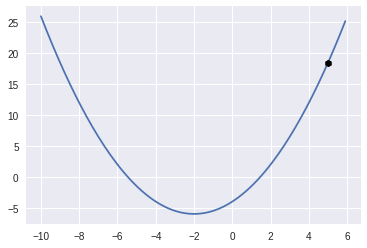

In [2]:
#CODIGO BASE

tf.reset_default_graph()

a, b, c, x_ini = (0.5, 2, -4, 5.0)

starting_val = tf.placeholder(tf.float64, shape=[])
x = tf.Variable(starting_val)
y = a*x**2 + b*x + c

num_steps = 20
x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])

learning_rate = 0.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op  = optimizer.minimize(y)
init_op   = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init_op, feed_dict={starting_val:x_ini})
    for i in range(num_steps):
        x_vals[i] = x.eval()
        y_vals[i] = y.eval()
        sess.run(train_op)

tf.summary.FileWriter('logs', tf.get_default_graph()).close()

#Funções de plot
x_plt = np.arange(-10,6,0.1)
y_plt  = a*x_plt**2 + b*x_plt + c
plt.plot(x_plt, y_plt)
plt.plot(x_vals,y_vals,'--x')
plt.plot(5,18.5,'hk') #ponto inicial
plt.plot(x_vals[-1],y_vals[-1],'hk') #ponto final
plt.show()

### Objetivo dos exemplos
Aprender a usar o parâmetro `Learning_rate` do otimizador `tf.train.GradientDescentOptimizer`.

### Exe. 1

* Tomando como referência o codigo do caso de estudo, ENCONTRE e imprima o valor do *learning rate* (taxa de aprendizado) para que haja convergência, sem que $x$ ultrapasse do mínimo ("sem overshoot"). 
* Para o *learning rate* ACHADO, plote os valores de $x$ e $y$ no processo iterativo. 

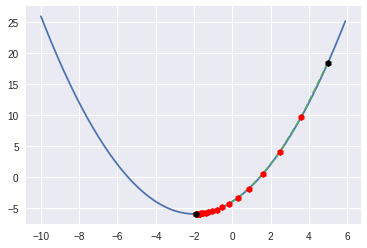

In [3]:
#CODIGO BASE

tf.reset_default_graph()

a, b, c, x_ini = (0.5, 2, -4, 5.0)

starting_val = tf.placeholder(tf.float64, shape=[])
x = tf.Variable(starting_val)
y = a*x**2 + b*x + c

num_steps = 20
x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])

learning_rate = tf.placeholder(tf.float32)
train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(y)

init_op   = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init_op, feed_dict={starting_val:x_ini})

    lr = .2
    for i in range(num_steps):
        x_vals[i] = x.eval()
        y_vals[i] = y.eval()
        sess.run(train_op, feed_dict={learning_rate:lr})

tf.summary.FileWriter('logs', tf.get_default_graph()).close()

#Funções de plot
x_plt = np.arange(-10,6,0.1)
y_plt  = a*x_plt**2 + b*x_plt + c
plt.plot(x_plt, y_plt)
plt.plot(x_vals,y_vals,'--x')
plt.plot(5,18.5,'hk') #ponto inicial
plt.plot(x_vals[1:-1],y_vals[1:-1],'hr') #pontos intermediários
plt.plot(x_vals[-1],y_vals[-1],'hk') #ponto final
plt.show()

### Exe. 2

* Tomando como referência o codigo do caso de estudo, ENCONTRE e imprima o valor do *learning rate* (taxa de aprendizado) para que haja convergência. 
  * Neste caso, $x$ deve ultrapassar o valor mínimo (**com overshoot**. Aqui, haverá um zigue-zague em torno do mínimo). 
* Para o *learning rate* ACHADO, plote os valores de $x$ e $y$ no processo iterativo.**bold text**

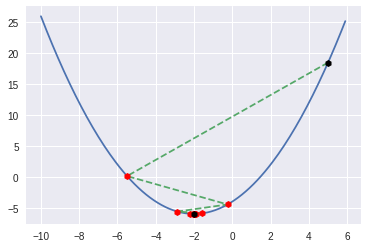

In [4]:
#CODIGO BASE

tf.reset_default_graph()

a, b, c, x_ini = (0.5, 2, -4, 5.0)

starting_val = tf.placeholder(tf.float64, shape=[])
x = tf.Variable(starting_val)
y = a*x**2 + b*x + c

num_steps = 20
x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])

learning_rate = tf.placeholder(tf.float32)
train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(y)

init_op   = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init_op, feed_dict={starting_val:x_ini})

    lr = 1.5
    for i in range(num_steps):
        x_vals[i] = x.eval()
        y_vals[i] = y.eval()
        sess.run(train_op, feed_dict={learning_rate:lr})

tf.summary.FileWriter('logs', tf.get_default_graph()).close()

#Funções de plot
x_plt = np.arange(-10,6,0.1)
y_plt  = a*x_plt**2 + b*x_plt + c
plt.plot(x_plt, y_plt)
plt.plot(x_vals,y_vals,'--x')
plt.plot(5,18.5,'hk') #ponto inicial
plt.plot(x_vals[1:-1],y_vals[1:-1],'hr') #pontos intermediários
plt.plot(x_vals[-1],y_vals[-1],'hk') #ponto final
plt.show()

### Exe. 3

* Tomando como referência o codigo do caso de estudo, ENCONTRE e imprima o valor do *learning rate* (taxa de aprendizado) para que haja divergência (ache o menor valor que conseguir para que haja divergência). 
  * Neste caso, $x$ não convergira para o valor mínimo. 
* Para o *learning rate* ACHADO, plote os valores de $x$ e $y$ no processo iterativo.

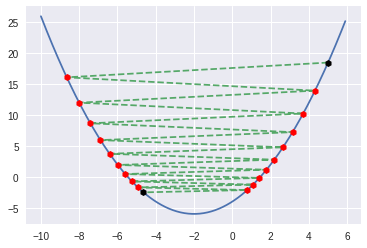

In [5]:
#CODIGO BASE

tf.reset_default_graph()

a, b, c, x_ini = (0.5, 2, -4, 5.0)

starting_val = tf.placeholder(tf.float64, shape=[])
x = tf.Variable(starting_val)
y = a*x**2 + b*x + c

num_steps = 20
x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])

learning_rate = tf.placeholder(tf.float32)
train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(y)

init_op   = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init_op, feed_dict={starting_val:x_ini})

    lr = 1.95
    for i in range(num_steps):
        x_vals[i] = x.eval()
        y_vals[i] = y.eval()
        sess.run(train_op, feed_dict={learning_rate:lr})

tf.summary.FileWriter('logs', tf.get_default_graph()).close()

#Funções de plot
x_plt = np.arange(-10,6,0.1)
y_plt  = a*x_plt**2 + b*x_plt + c
plt.plot(x_plt, y_plt)
plt.plot(x_vals,y_vals,'--x')
plt.plot(5,18.5,'hk') #ponto inicial
plt.plot(x_vals[1:-1],y_vals[1:-1],'hr') #pontos intermediários
plt.plot(x_vals[-1],y_vals[-1],'hk') #ponto final
plt.show()

### Exe. 4

Para as seguintes funções definidas pelas expressões:
$$
\begin{eqnarray}
f(x) &=& log(1+|x|^{2+sin(x)})\\
f(x) &=& (2+\frac{sin(50x)}{50})(\arctan(x)^2)\\
f(x) &=& |\lfloor x \rfloor  - 50|
\end{eqnarray}
$$
Tomando como referência o codigo do caso de estudo, ENCONTRE O VALOR MINIMO para cada função usando alguns dos otimizadores de tensorflow.

**OBS**. Para ver uma animação das diferentes funções a otimizar ver: [An Interactive Tutorial on Numerical Optimization](https://www.benfrederickson.com/numerical-optimization/)

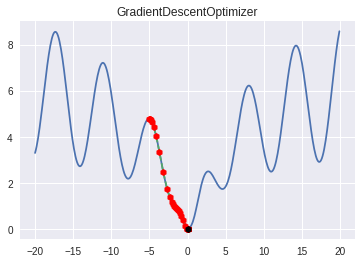

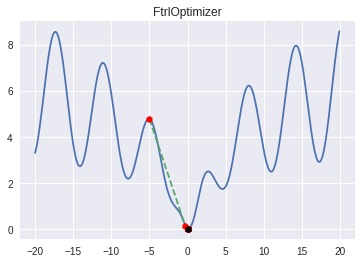

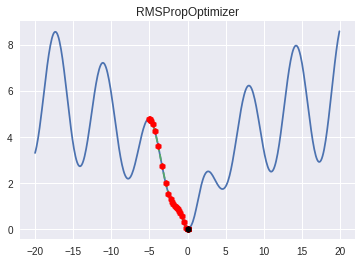

In [6]:
#CODIGO BASE

tf.reset_default_graph()

a, b, c, x_ini = (0.5, 2, -4, -5.0)

starting_val = tf.placeholder(tf.float64, shape=[])
x = tf.Variable(starting_val)
y = tf.log(1+np.power(np.abs(x),2+tf.sin(x))) # Função

num_steps = 45
x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])

learning_rate = tf.placeholder(tf.float32)
train_op1 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(y)
train_op2 = tf.train.FtrlOptimizer(learning_rate=learning_rate).minimize(y)
train_op3 = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(y)

init_op   = tf.global_variables_initializer()

def plot_graph(x_ini, x_vals, y_vals, title):
  x_plt = np.arange(-20,20,0.1) # Limites do gráfico
  y_plt  = np.log(1+np.power(np.abs(x_plt),2+np.sin(x_plt))) # Função gráfica
  
  plt.plot(x_plt, y_plt)
  plt.plot(x_vals,y_vals,'--x')
  plt.plot(x_ini,np.log(1+np.power(np.abs(x_ini),2+np.sin(x_ini))),'hr') # Plotar pontos iniciais
  plt.plot(x_vals[1:-1],y_vals[1:-1],'hr') #pontos intermediários
  plt.plot(x_vals[-1],y_vals[-1],'hk') #ponto final
  plt.title(title)
  plt.show()
  

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op1, feed_dict={learning_rate:0.3})
    
  plot_graph(x_ini, x_vals, y_vals, 'GradientDescentOptimizer') 
  
  
with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op2, feed_dict={learning_rate:0.3})   
    
  plot_graph(x_ini, x_vals, y_vals, 'FtrlOptimizer')
  
with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op3, feed_dict={learning_rate:0.3})
    
  plot_graph(x_ini, x_vals, y_vals, 'RMSPropOptimizer')

tf.summary.FileWriter('logs', tf.get_default_graph()).close()

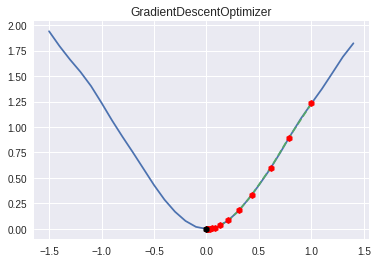

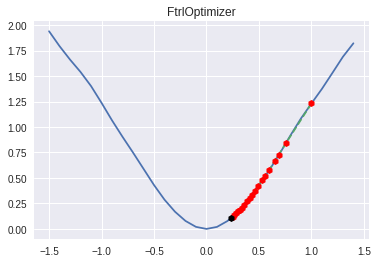

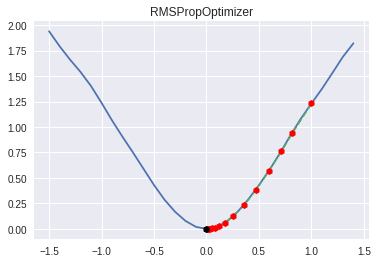

In [7]:
#CODIGO BASE

tf.reset_default_graph()

a, b, c, x_ini = (0.5, 2, -4, 1.0)

starting_val = tf.placeholder(tf.float64, shape=[])
x = tf.Variable(starting_val)
y = (2+(tf.sin(50*x)/50))*(tf.atan(x)**2)

num_steps = 20
x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])

learning_rate = tf.placeholder(tf.float32)
train_op1 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(y)
train_op2 = tf.train.FtrlOptimizer(learning_rate=learning_rate).minimize(y)
train_op3 = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(y)

init_op   = tf.global_variables_initializer()

def plot_graph(x_ini, x_vals, y_vals, title):
  x_plt = np.arange(-1.5,1.5,0.1) #Limites do gráfico
  y_plt  = (2+(np.sin(50*x_plt)/50))*(np.arctan(x_plt)**2) # Função grafica

  plt.plot(x_plt, y_plt)
  plt.plot(x_vals,y_vals,'--x')
  plt.plot(x_ini,(2+(np.sin(50*x_ini)/50))*(np.arctan(x_ini)**2),'hr') # Plotar pontos iniciais
  plt.plot(x_vals[1:-1],y_vals[1:-1],'hr') #pontos intermediários
  plt.plot(x_vals[-1],y_vals[-1],'hk') #ponto final
  plt.title(title)
  plt.show()
  

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op1, feed_dict={learning_rate:0.1})
    
  plot_graph(x_ini, x_vals, y_vals, 'GradientDescentOptimizer') 
  
  
with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op2, feed_dict={learning_rate:0.1})   
    
  plot_graph(x_ini, x_vals, y_vals, 'FtrlOptimizer')
  
with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op3, feed_dict={learning_rate:0.1})
    
  plot_graph(x_ini, x_vals, y_vals, 'RMSPropOptimizer')

tf.summary.FileWriter('logs', tf.get_default_graph()).close()

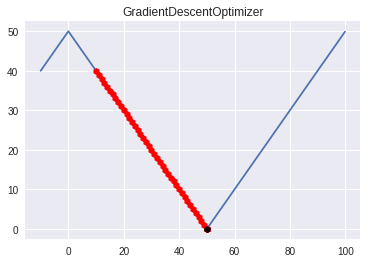

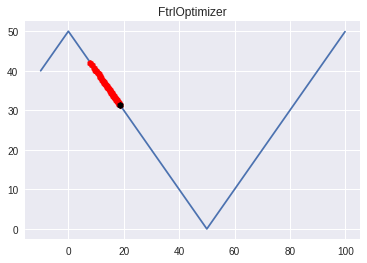

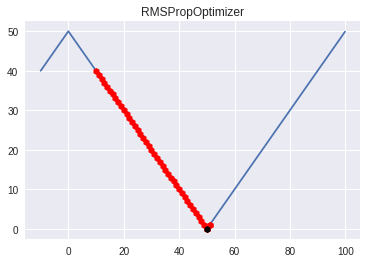

In [8]:
#CODIGO BASE

tf.reset_default_graph()

a, b, c, x_ini = (0.5, 2, -4, 10)

starting_val = tf.placeholder(tf.float64, shape=[])
x = tf.Variable(starting_val)
y = np.abs(np.abs(x)-50)

num_steps = 45
x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])

learning_rate = tf.placeholder(tf.float32)
train_op1 = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(y)
train_op2 = tf.train.FtrlOptimizer(learning_rate=learning_rate).minimize(y)
train_op3 = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(y)

init_op   = tf.global_variables_initializer()

def plot_graph(x_ini, x_vals, y_vals, title):
  x_plt = np.arange(-10,100,0.1) #Limites do grafico
  y_plt  = np.abs(np.abs(x_plt)-50) # Função grafica
  
  plt.plot(x_plt, y_plt)
  plt.plot(x_vals,y_vals,'--x')
  plt.plot(x_ini,np.abs(np.abs(x_ini)-50),'hr') # Plotar pontos iniciais
  plt.plot(x_vals[1:-1],y_vals[1:-1],'hr') #pontos intermediários
  plt.plot(x_vals[-1],y_vals[-1],'hk') #ponto final
  plt.title(title)
  plt.show()
  

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op1, feed_dict={learning_rate:1})
    
  plot_graph(x_ini, x_vals, y_vals, 'GradientDescentOptimizer') 
  
  
with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op2, feed_dict={learning_rate:1})   
    
  plot_graph(x_ini, x_vals, y_vals, 'FtrlOptimizer')
  
with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val:x_ini})

  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    sess.run(train_op3, feed_dict={learning_rate:1})
    
  plot_graph(x_ini, x_vals, y_vals, 'RMSPropOptimizer')

tf.summary.FileWriter('logs', tf.get_default_graph()).close()

## Exercícios de otimização 2D

### Caso de estudo

O seguinte codigo permite aplicar o algoritmo GSD via o otimizador de gradiente descendente (`tf.train.GradientDescentOptimizer`) para achar o mínimo de uma função de Zakharov: 
$$
f(x,y) = (x^2 + y^2) + (0.5x + y)^2 + (0.5x + y)^4
$$

considerando que o valor inicial é:
$$
(x_{ini},y_{ini}) = (8.0,8.0)
$$

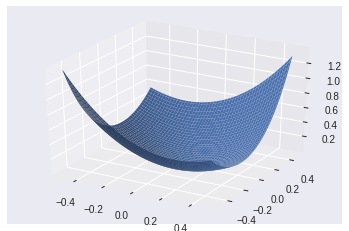

In [9]:
def zakharov(x, y):
  return (x**2 + y**2) + (0.5*x + y)**2 + (0.5*x + y)**4

x = np.arange(-0.5, 0.5, 0.01)
y = np.arange(-0.5, 0.5, 0.01)
X, Y = np.meshgrid(x, y)
Z = zakharov(X, Y)

fig = plt.figure(1)
ax = fig.gca(projection = '3d')
# Plot the surface.
surf5 = ax.plot_surface(X, Y, Z)
plt.show()

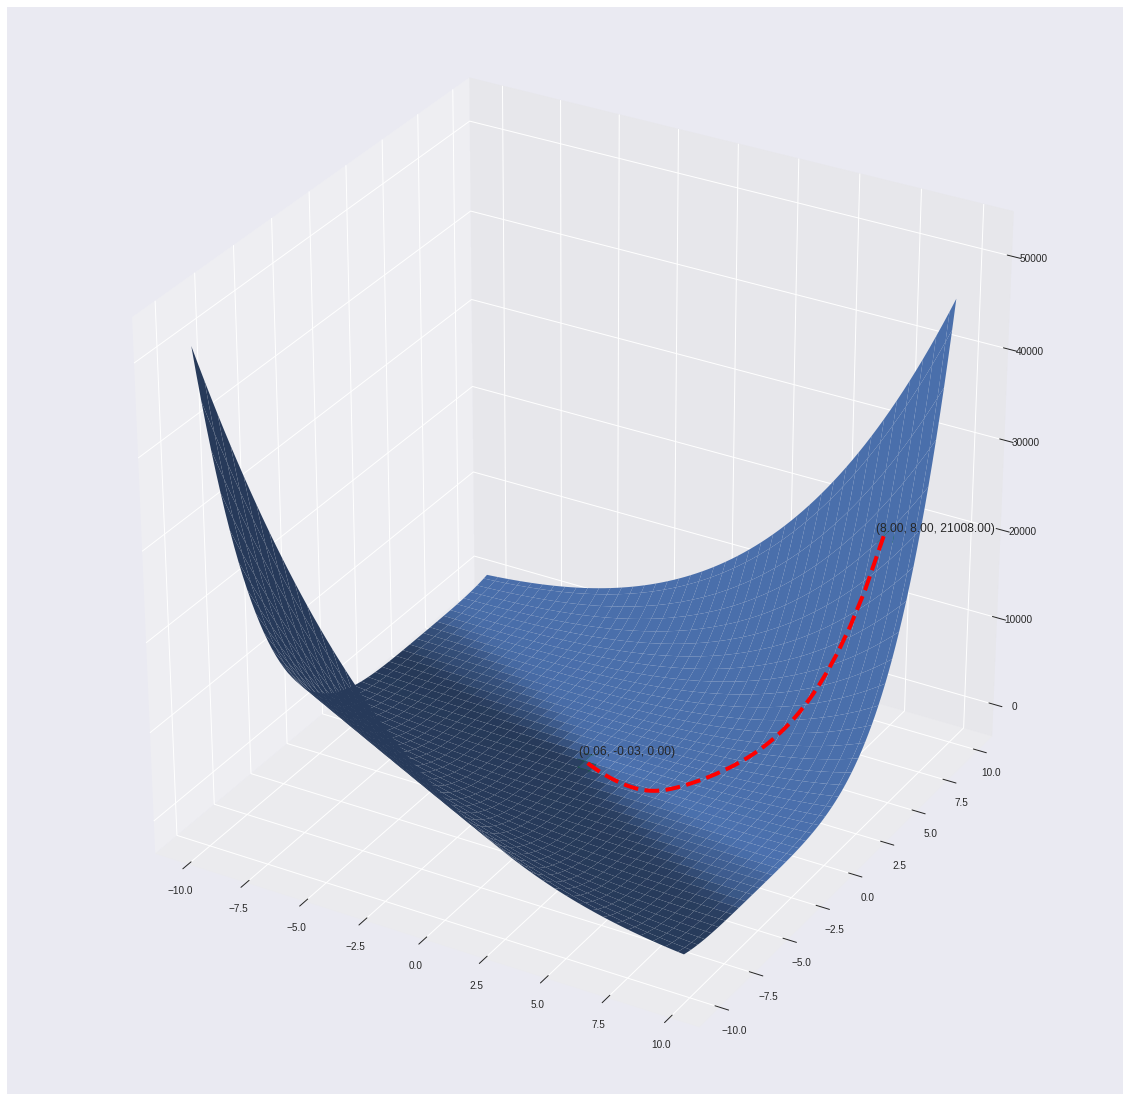

In [10]:
tf.reset_default_graph()

x_ini, y_ini = (8.0, 8.0)
z_ini = zakharov(x_ini, y_ini)


# zakharov's function
starting_val_x = tf.placeholder(tf.float32, shape=[])
starting_val_y = tf.placeholder(tf.float32, shape=[])
x = tf.Variable(starting_val_x)
y = tf.Variable(starting_val_y)
z = tf.add_n([tf.add(tf.square(x), tf.square(y)), tf.square(tf.add(tf.multiply(0.5, x), y)), tf.pow(tf.add(tf.multiply(0.5, x),y), 4.)])



num_steps = 20000
x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])
z_vals = np.empty([num_steps])

learning_rate = 0.0001

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op  = optimizer.minimize(z)
init_op   = tf.global_variables_initializer()


with tf.Session() as sess:
    sess.run(init_op, feed_dict={starting_val_x:x_ini,starting_val_y:y_ini})
    for i in range(num_steps):
        x_vals[i] = x.eval()
        y_vals[i] = y.eval()
        z_vals[i] = z.eval()
#         print(z_vals[i])
        sess.run(train_op)
        

tf.summary.FileWriter('logs', tf.get_default_graph()).close()

#Funções de plot
xmin, xmax = -10, 10
ymin, ymax = -10, 10
x_plt = np.arange(xmin, xmax, 0.25)
y_plt = np.arange(ymin, ymax, 0.25)
X_plt, Y_plt = np.meshgrid(x_plt, y_plt)
Z_plt = zakharov(X_plt, Y_plt)

fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection = '3d')
# Plot the surface.
ax.plot_surface(X_plt, Y_plt, Z_plt)
ax.plot3D(x_vals,y_vals,z_vals,'--x', linewidth=4.0, color='r')
ax.text(x_vals[0]-0.3,y_vals[0],(z_vals[0]+300),  "({:.2f}, {:.2f}, {:.2f})".format(x_vals[0],y_vals[0],z_vals[0]), fontsize=12)
ax.scatter3D(x_vals[0],y_vals[0],z_vals[0],s = 400, color='g') #ponto inicial
ax.text(x_vals[-1]-0.3,y_vals[-1],(z_vals[-1]+600),  "({:.2f}, {:.2f}, {:.2f})".format(x_vals[-1],y_vals[-1],z_vals[-1]), fontsize=12)
ax.scatter3D(x_vals[-1],y_vals[-1],z_vals[-1],s = 400, color='g') #ponto final
#ax.view_init(elev=20., azim=-35)
plt.show()

### Exe. 1




Para as seguintes funções definidas pelas expressões:

$$
\begin{eqnarray}
f(x,y) &=& (x^2 + y -11)^2 + (x + y^2 -7)^2\\
f(x,y) &=& x^2 + y^2 +x\sin(y) +y\sin(x) \\
f(x,y) &=& (1-x)^2 + 100(y-x^2)^2 \\
f(x,y) &=& 0.26(x^2 + y^2) + 0.48xy \\
f(x,y) &=& x^2 + 2*y^2 - 0.3*\cos(3 \pi x) - 0.4\cos(4 \pi y) + 0.7\\
f(x,y) &=& (x-1)^2 + (y-1)^2 - xy
\end{eqnarray}
$$

Tomando como referência o codigo do caso de estudo, ENCONTRE O VALOR MINIMO para cada função usando alguns dos otimizadores de tensorflow.

**OBS**. Para ver uma animação das diferentes funções a otimizar ver: [An Interactive Tutorial on Numerical Optimization](https://www.benfrederickson.com/numerical-optimization/)

In [0]:
def func_1(x, y):
  return np.power((np.power(x,2)+y-11),2) +  np.power((x+np.power(y,2)-7),2)

def func_2(x, y):
  return np.power(x,2)+np.power(y,2)+x*np.sin(y)+y*np.sin(x)

def func_3(x, y):
  return np.power(1-x,2)+100*(np.power(y-np.power(x,2),2))

def func_4(x, y):
  return 0.26*(np.power(x,2)+np.power(y,2))+0.48*x*y

def func_5(x, y):
  return np.power(x,2) + 2*np.power(y,2) - 0.3*np.cos(3*np.pi*x)- 0.4*np.cos(4*np.pi*y)+0.7

def func_6(x, y):
  return np.power(x-1,2)+np.power(y-1,2)-x*y            

def plot_func(func_x):
  #Funções de plot
  xmin, xmax = -10, 10
  ymin, ymax = -10, 10
  x_plt = np.arange(xmin, xmax, 0.25)
  y_plt = np.arange(ymin, ymax, 0.25)
  X_plt, Y_plt = np.meshgrid(x_plt, y_plt)
  Z_plt = func_x(X_plt, Y_plt)

  fig = plt.figure(figsize=(20,20))
  ax = fig.gca(projection = '3d')

  # Plot the surface.
  ax.plot_surface(X_plt, Y_plt, Z_plt)
  ax.plot3D(x_vals,y_vals,z_vals,'--x', linewidth=4.0, color='r')
  ax.text(x_vals[0]-0.3,y_vals[0],(z_vals[0]+300),  "({:.2f}, {:.2f}, {:.2f})".format(x_vals[0],y_vals[0],z_vals[0]), fontsize=12)
  ax.scatter3D(x_vals[0],y_vals[0],z_vals[0],s = 400, color='g') #ponto inicial
  ax.text(x_vals[-1]-0.3,y_vals[-1],(z_vals[-1]+600),  "({:.2f}, {:.2f}, {:.2f})".format(x_vals[-1],y_vals[-1],z_vals[-1]), fontsize=12)
  ax.scatter3D(x_vals[-1],y_vals[-1],z_vals[-1],s = 400, color='g') #ponto final
#   ax.view_init(elev=40., azim=0)
  plt.show()

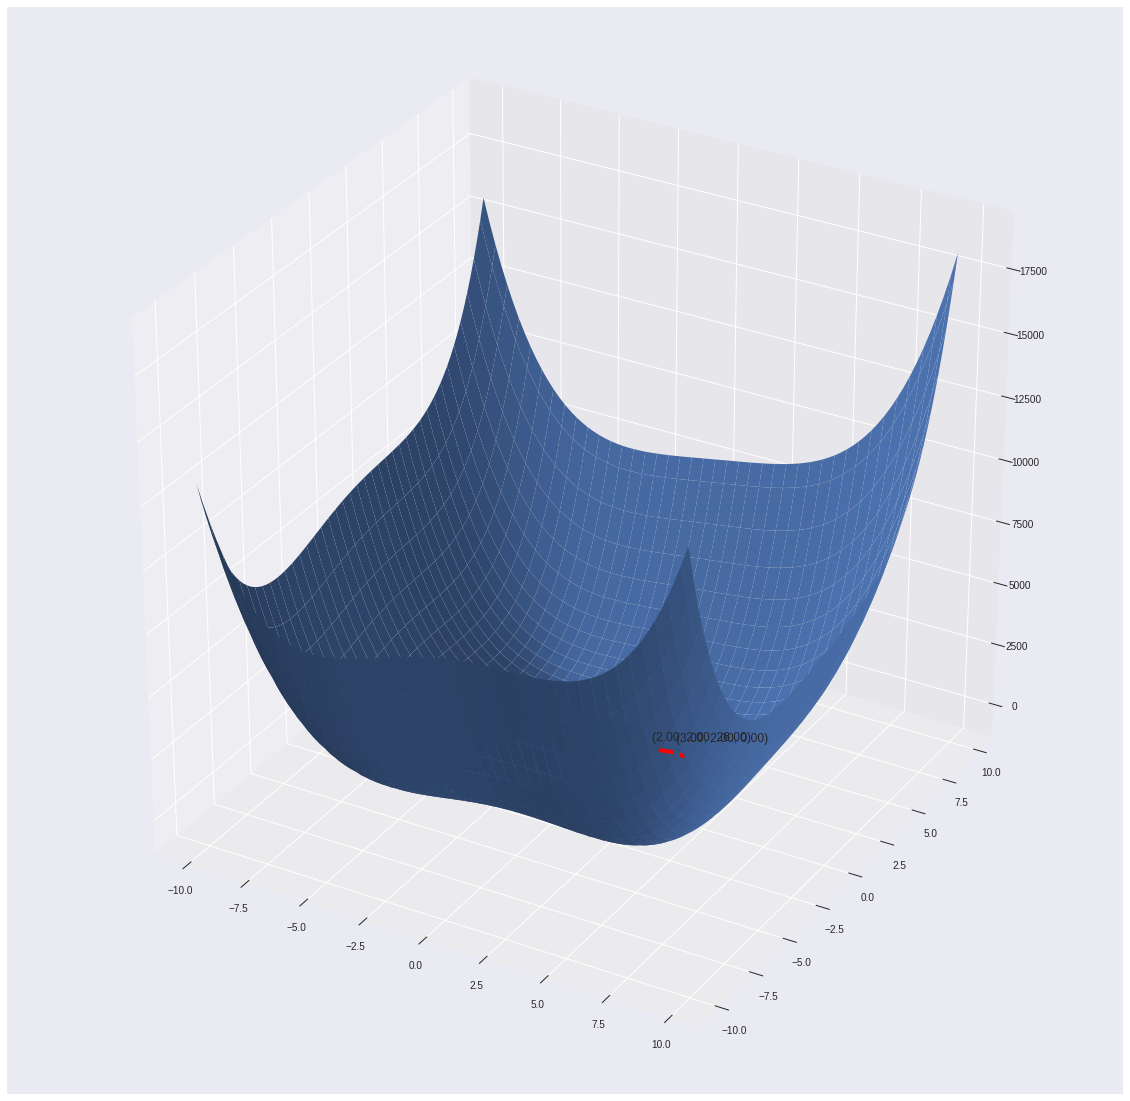

In [12]:
tf.reset_default_graph()

starting_val_x = tf.placeholder(tf.float32, shape=[])
starting_val_y = tf.placeholder(tf.float32, shape=[])
learning_rate = tf.placeholder(tf.float32)

x = tf.Variable(starting_val_x)
y = tf.Variable(starting_val_y)

# Equation 1:
num_steps = 200
x_ini, y_ini = (2.0, 2.0)
z_ini = func_1(x_ini, y_ini)
z = tf.add(tf.square(tf.add(tf.square(x), y -11)), tf.square(tf.add(x,tf.square(y)-7)))

x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])
z_vals = np.empty([num_steps])

train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(z)
init_op   = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val_x:x_ini,starting_val_y:y_ini})
  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    z_vals[i] = z.eval()
    sess.run(train_op, feed_dict={learning_rate:0.001})
  plot_func(func_1)
        
tf.summary.FileWriter('logs', tf.get_default_graph()).close()

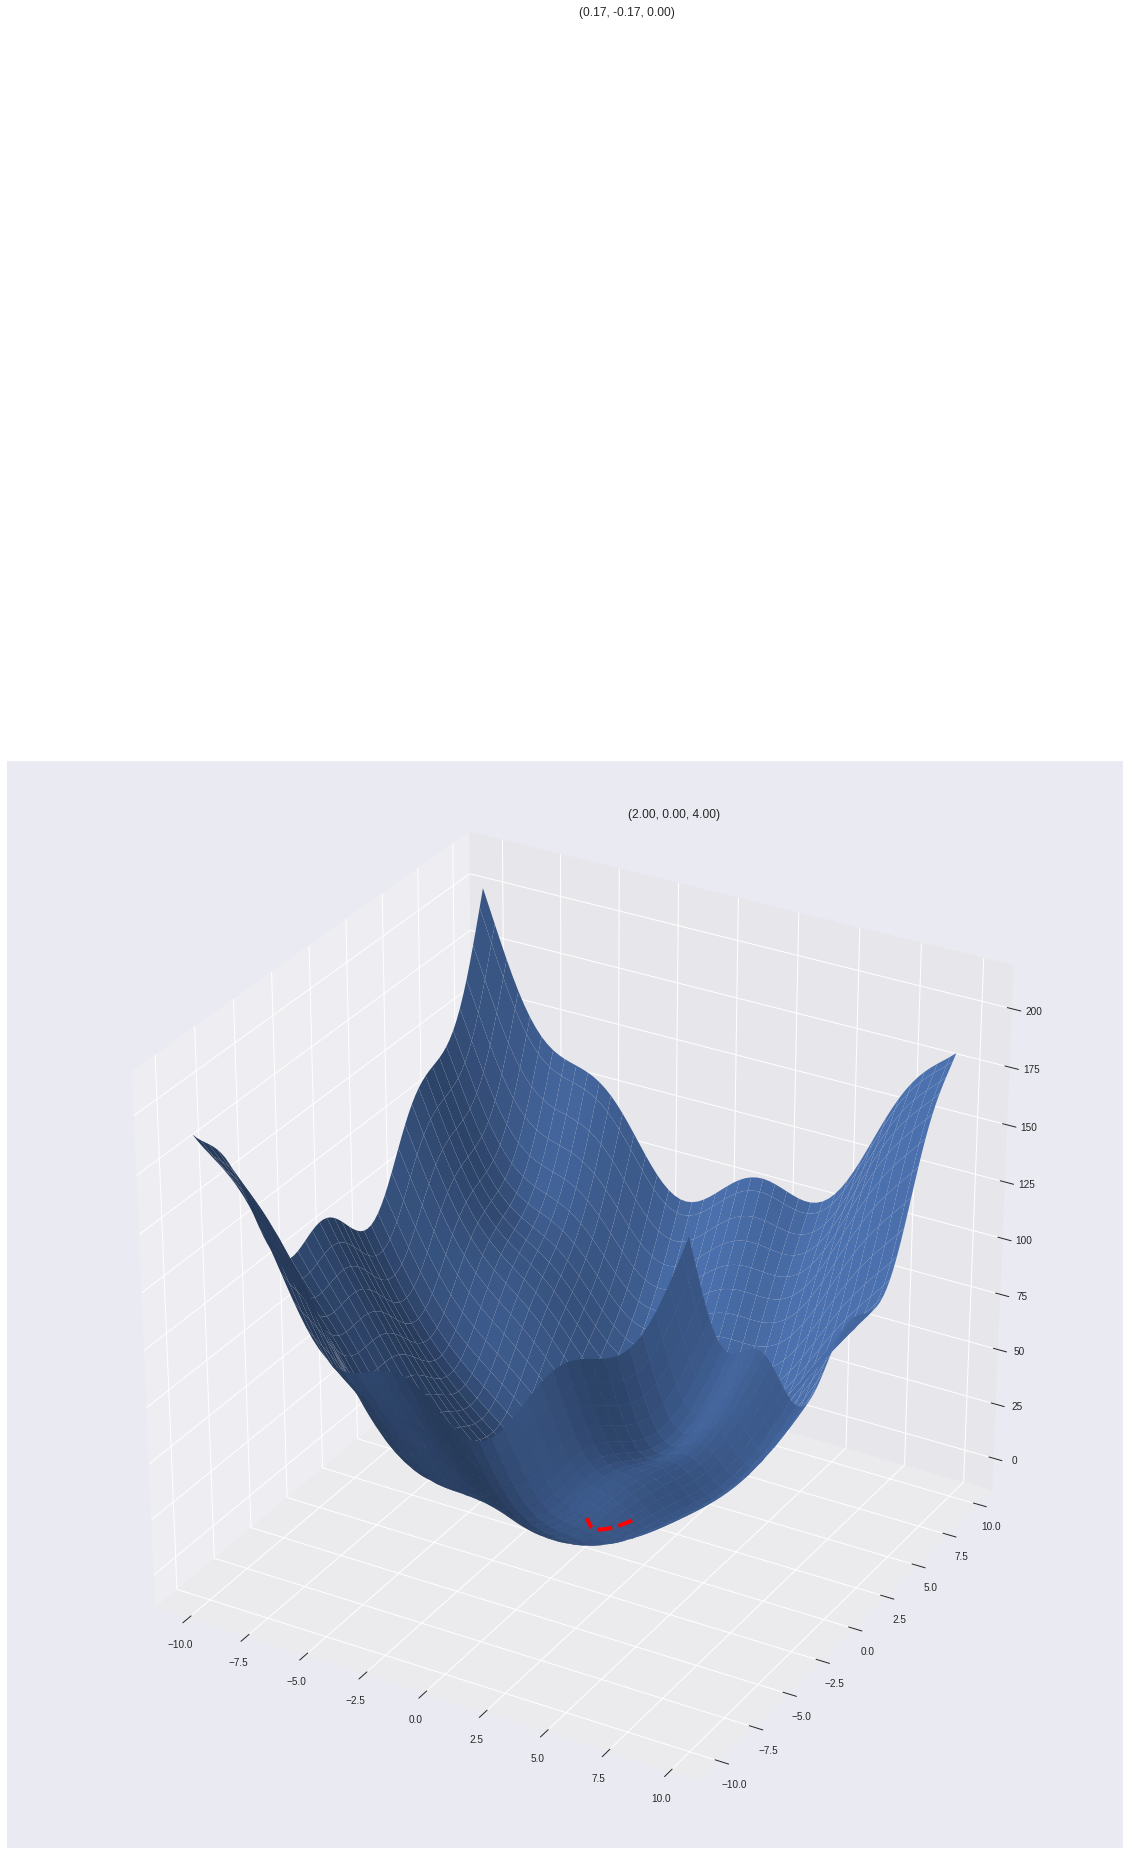

In [13]:
tf.reset_default_graph()

starting_val_x = tf.placeholder(tf.float32, shape=[])
starting_val_y = tf.placeholder(tf.float32, shape=[])
learning_rate = tf.placeholder(tf.float32)

x = tf.Variable(starting_val_x)
y = tf.Variable(starting_val_y)

# Equation 2:
num_steps = 250
x_ini, y_ini = (2.0, 0.0)
z_ini = func_2(x_ini, y_ini)
z = tf.add_n([tf.square(x),tf.square(y),x*tf.sin(y),y*tf.sin(x)])

x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])
z_vals = np.empty([num_steps])

train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(z)
init_op   = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val_x:x_ini,starting_val_y:y_ini})
  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    z_vals[i] = z.eval()
    sess.run(train_op, feed_dict={learning_rate:0.1})
  plot_func(func_2)
        
tf.summary.FileWriter('logs', tf.get_default_graph()).close()

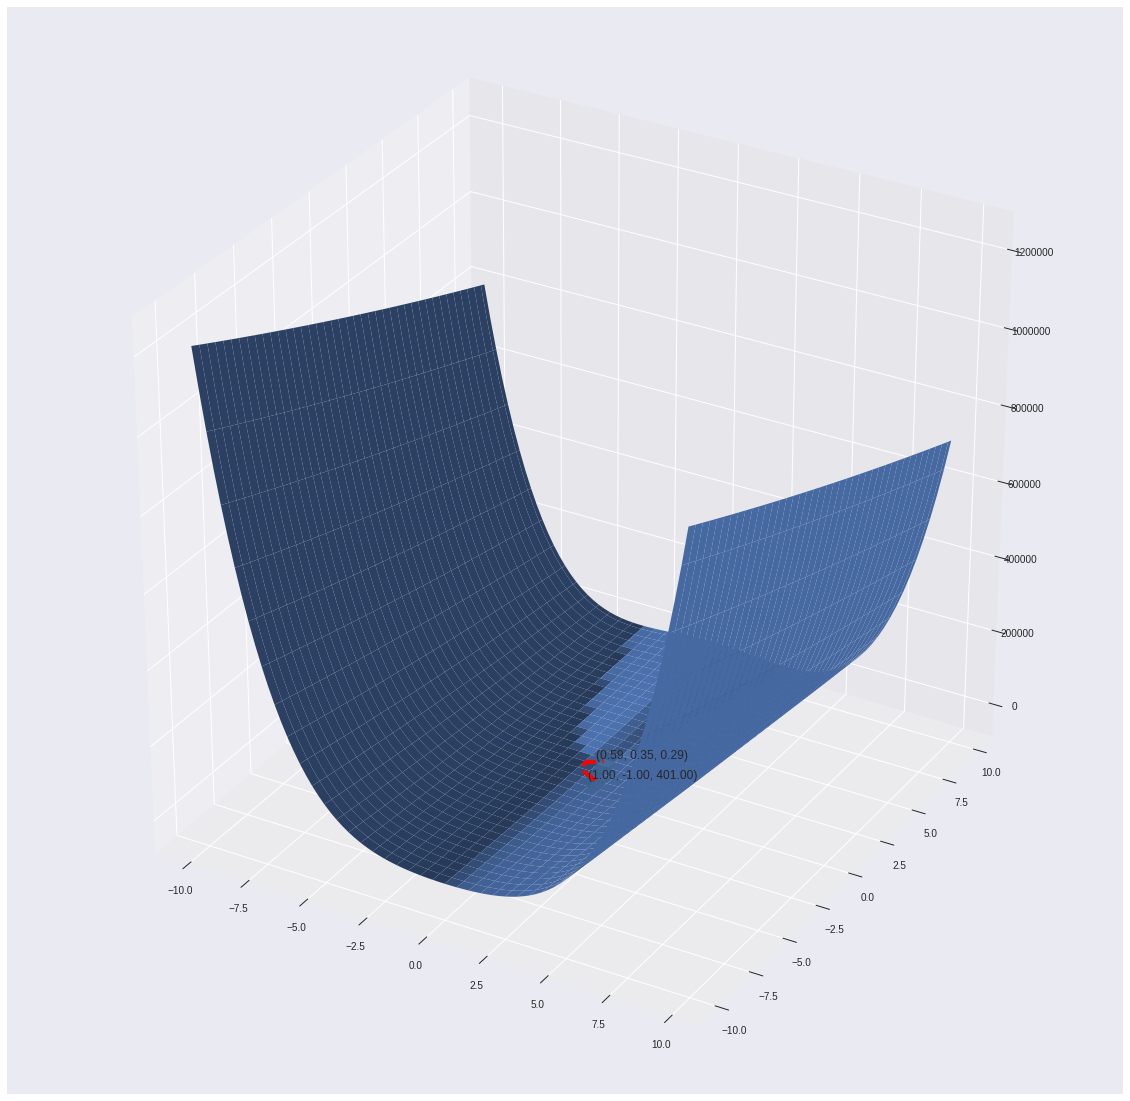

In [14]:
tf.reset_default_graph()

starting_val_x = tf.placeholder(tf.float32, shape=[])
starting_val_y = tf.placeholder(tf.float32, shape=[])
learning_rate = tf.placeholder(tf.float32)

x = tf.Variable(starting_val_x)
y = tf.Variable(starting_val_y)

# Equation 3:
num_steps = 5000
x_ini, y_ini = (1.0, -1.0)
z_ini = func_3(x_ini, y_ini)
z = tf.add_n([tf.square(1-x),tf.square(y),100*tf.square(y-tf.square(x))])

x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])
z_vals = np.empty([num_steps])

train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(z)
init_op   = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val_x:x_ini,starting_val_y:y_ini})
  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    z_vals[i] = z.eval()
    sess.run(train_op, feed_dict={learning_rate:0.001})
  plot_func(func_3)
        
tf.summary.FileWriter('logs', tf.get_default_graph()).close()

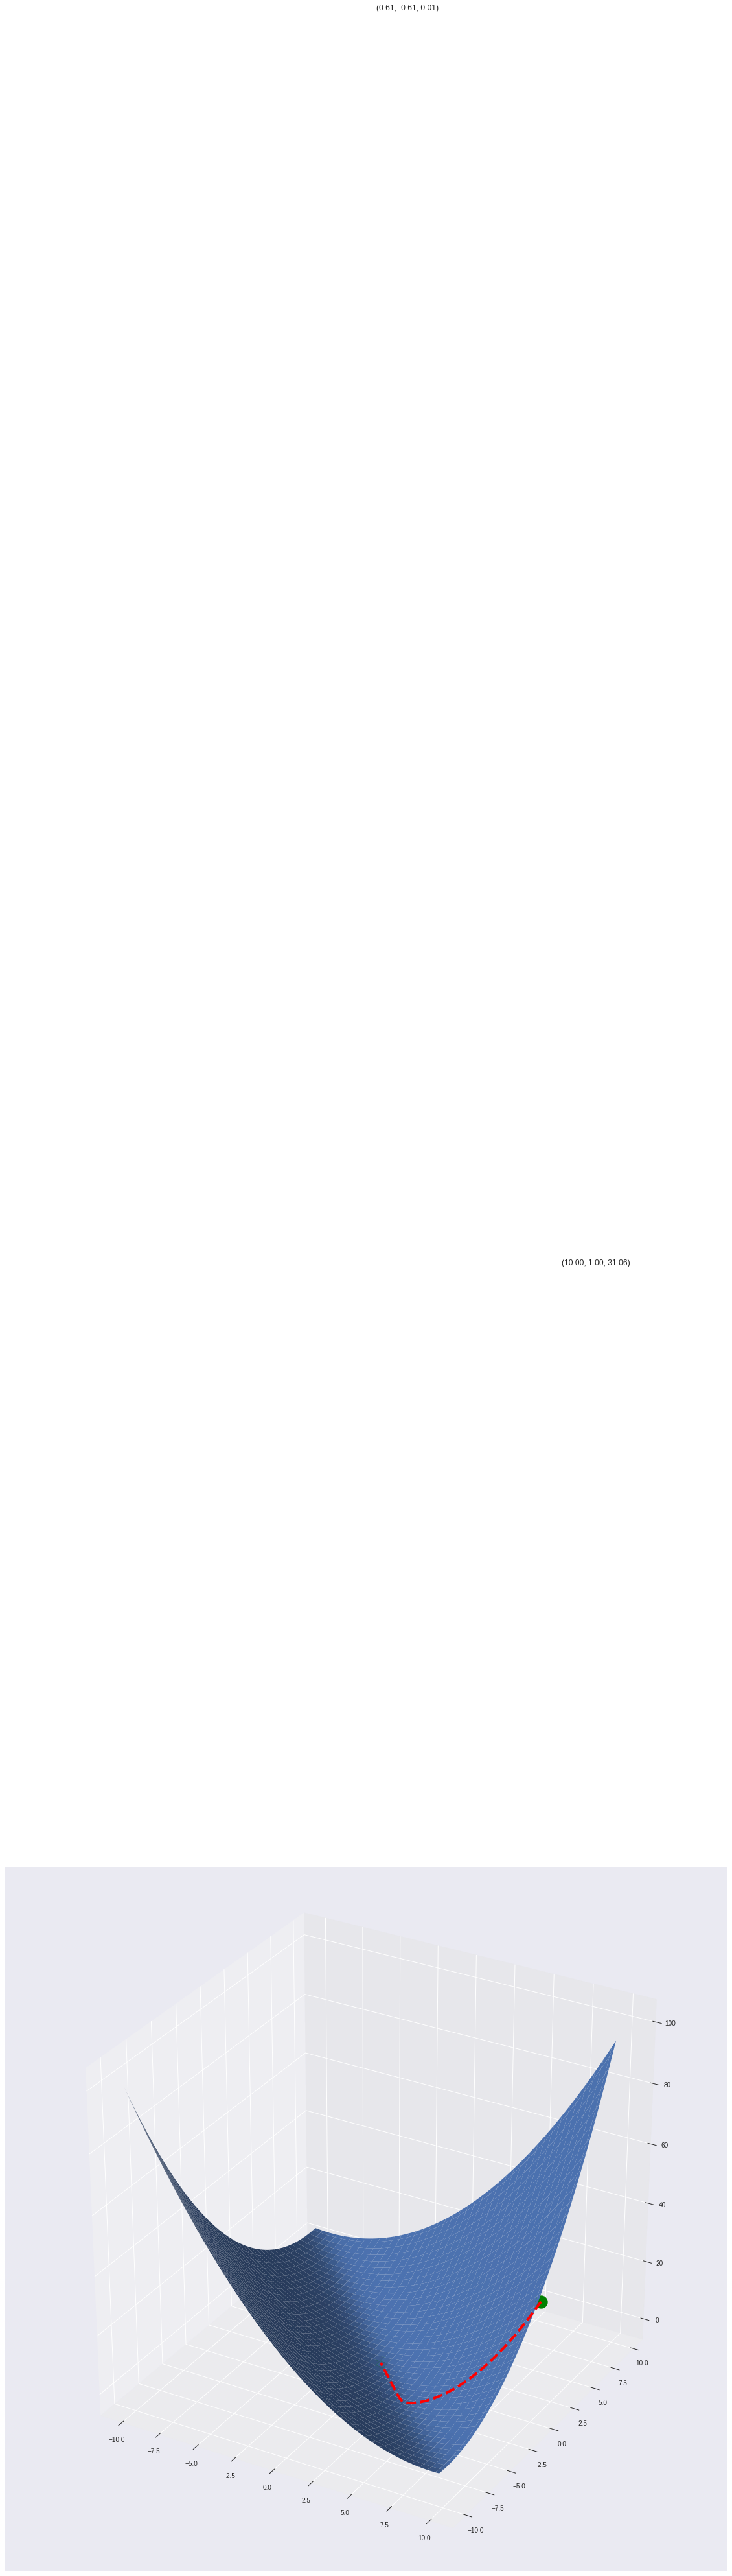

In [15]:
tf.reset_default_graph()

starting_val_x = tf.placeholder(tf.float32, shape=[])
starting_val_y = tf.placeholder(tf.float32, shape=[])
learning_rate = tf.placeholder(tf.float32)

x = tf.Variable(starting_val_x)
y = tf.Variable(starting_val_y)

# Equation 4:
num_steps = 500
x_ini, y_ini = (10.0, 1.0)
z_ini = func_4(x_ini, y_ini)
z = tf.add(0.26*tf.add(tf.square(x),tf.square(y)),0.48*x*y)

x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])
z_vals = np.empty([num_steps])

train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(z)
init_op   = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val_x:x_ini,starting_val_y:y_ini})
  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    z_vals[i] = z.eval()
    sess.run(train_op, feed_dict={learning_rate:0.1})
  plot_func(func_4)
        
tf.summary.FileWriter('logs', tf.get_default_graph()).close()

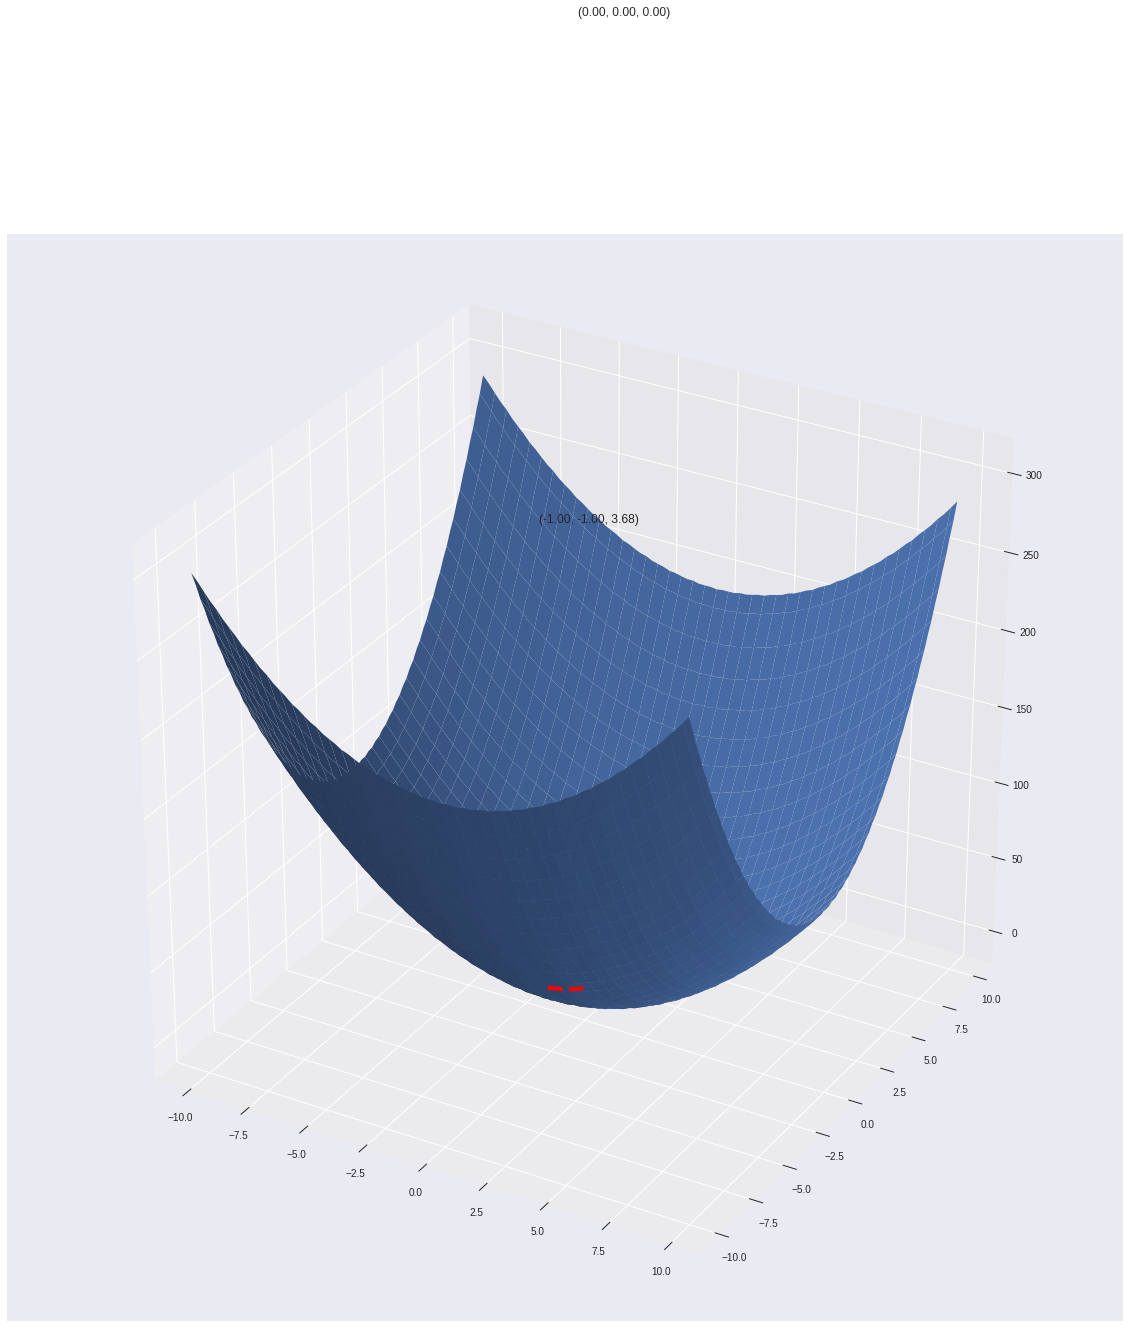

In [16]:
tf.reset_default_graph()

starting_val_x = tf.placeholder(tf.float32, shape=[])
starting_val_y = tf.placeholder(tf.float32, shape=[])
learning_rate = tf.placeholder(tf.float32)

x = tf.Variable(starting_val_x)
y = tf.Variable(starting_val_y)

# Equation 5:
num_steps = 1000
x_ini, y_ini = (-1.0, -1.0)
z_ini = func_5(x_ini, y_ini)
z = tf.add_n([tf.square(x),tf.square(y),x*tf.sin(y),y*tf.sin(x)])

x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])
z_vals = np.empty([num_steps])

train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(z)
init_op   = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val_x:x_ini,starting_val_y:y_ini})
  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    z_vals[i] = z.eval()
    sess.run(train_op, feed_dict={learning_rate:0.1})
  plot_func(func_5)
        
tf.summary.FileWriter('logs', tf.get_default_graph()).close()

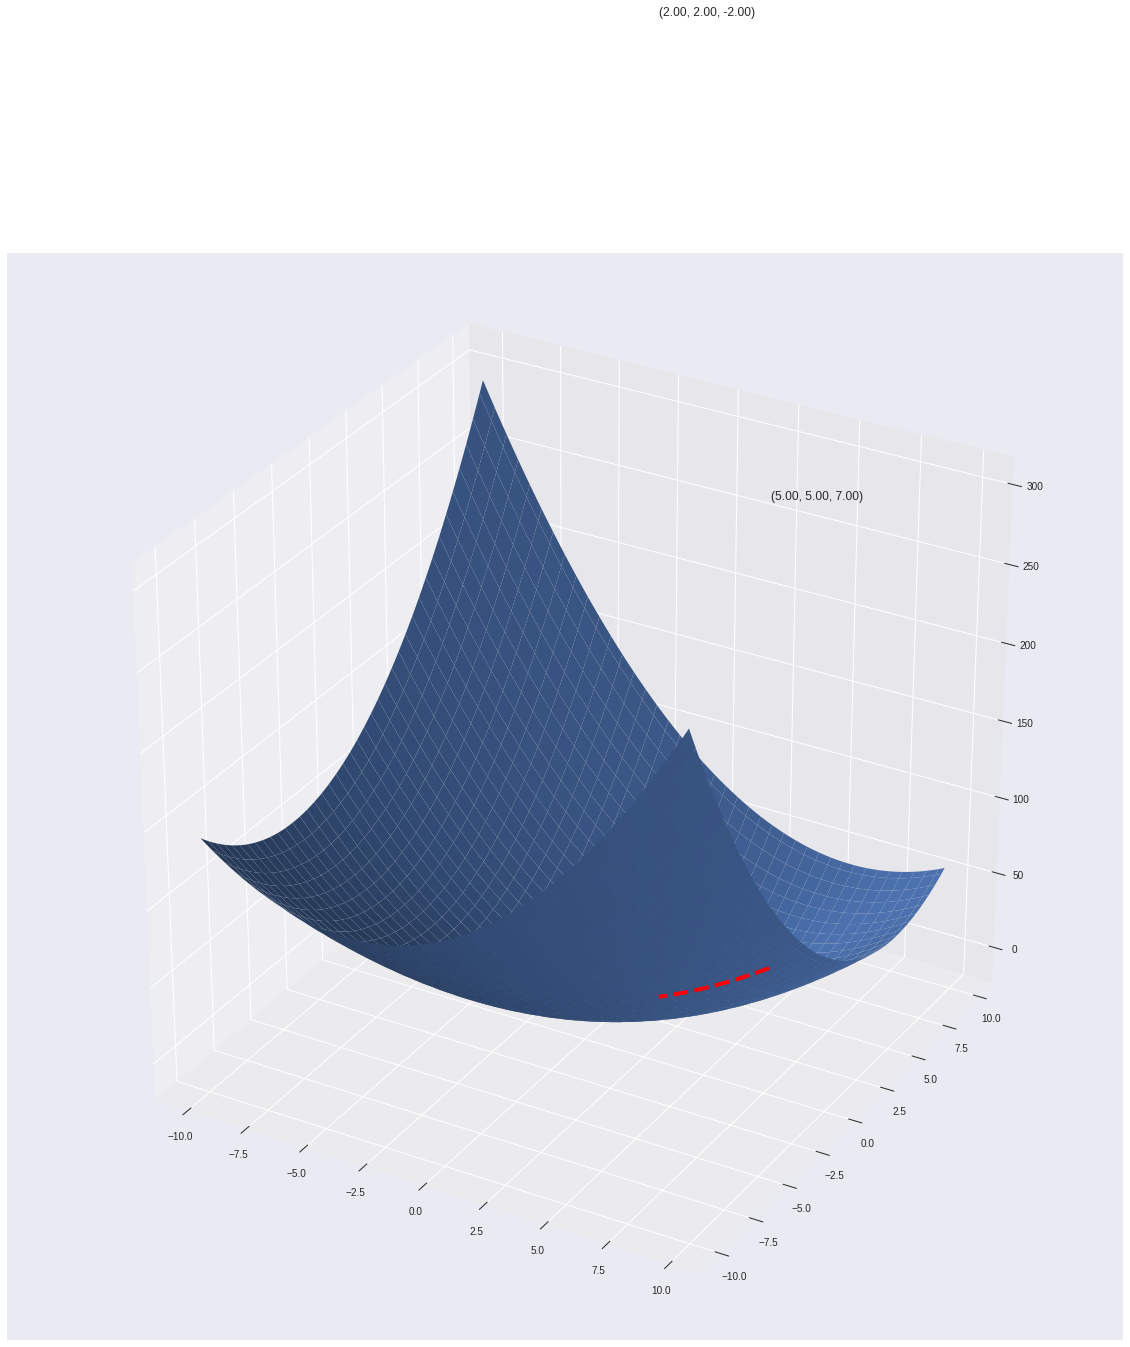

In [17]:
tf.reset_default_graph()

starting_val_x = tf.placeholder(tf.float32, shape=[])
starting_val_y = tf.placeholder(tf.float32, shape=[])
learning_rate = tf.placeholder(tf.float32)

x = tf.Variable(starting_val_x)
y = tf.Variable(starting_val_y)

# Equation 6:
num_steps = 3000
x_ini, y_ini = (5.0, 5.0)
z_ini = func_6(x_ini, y_ini)
z = z = tf.add_n([tf.square(x-1),tf.square(y-1),-x*y])

x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])
z_vals = np.empty([num_steps])

train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(z)
init_op   = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val_x:x_ini,starting_val_y:y_ini})
  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    z_vals[i] = z.eval()
    sess.run(train_op, feed_dict={learning_rate:0.01})
  plot_func(func_6)
        
tf.summary.FileWriter('logs', tf.get_default_graph()).close()

### Exe. 2

Para a seguinte função:
$$
f(x,y) = \exp{\left(-\frac{1}{0.1x^2 + y^2}\right)}
$$
Determinar seu minimo valor usando SGD. 

In [0]:
def func_7(x, y):
  return np.exp(-1/(0.1*np.power(x,2)+np.power(y,2)))

def plot_func(func_x):
  #Funções de plot
  xmin, xmax = -30, 30
  ymin, ymax = -10, 10
  x_plt = np.arange(xmin, xmax, 0.25)
  y_plt = np.arange(ymin, ymax, 0.25)
  X_plt, Y_plt = np.meshgrid(x_plt, y_plt)
  Z_plt = func_x(X_plt, Y_plt)

  fig = plt.figure(figsize=(20,20))
  ax = fig.gca(projection = '3d')

  # Plot the surface.
  ax.plot_surface(X_plt, Y_plt, Z_plt)
  ax.plot3D(x_vals,y_vals,z_vals,'--x', linewidth=4.0, color='r')
  ax.text(x_vals[0]-0.3,y_vals[0],(z_vals[0]+300),  "({:.2f}, {:.2f}, {:.2f})".format(x_vals[0],y_vals[0],z_vals[0]), fontsize=12)
  ax.scatter3D(x_vals[0],y_vals[0],z_vals[0],s = 400, color='g') #ponto inicial
  ax.text(x_vals[-1]-0.3,y_vals[-1],(z_vals[-1]+600),  "({:.2f}, {:.2f}, {:.2f})".format(x_vals[-1],y_vals[-1],z_vals[-1]), fontsize=12)
  ax.scatter3D(x_vals[-1],y_vals[-1],z_vals[-1],s = 400, color='g') #ponto final
#   ax.view_init(elev=40., azim=0)
  plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


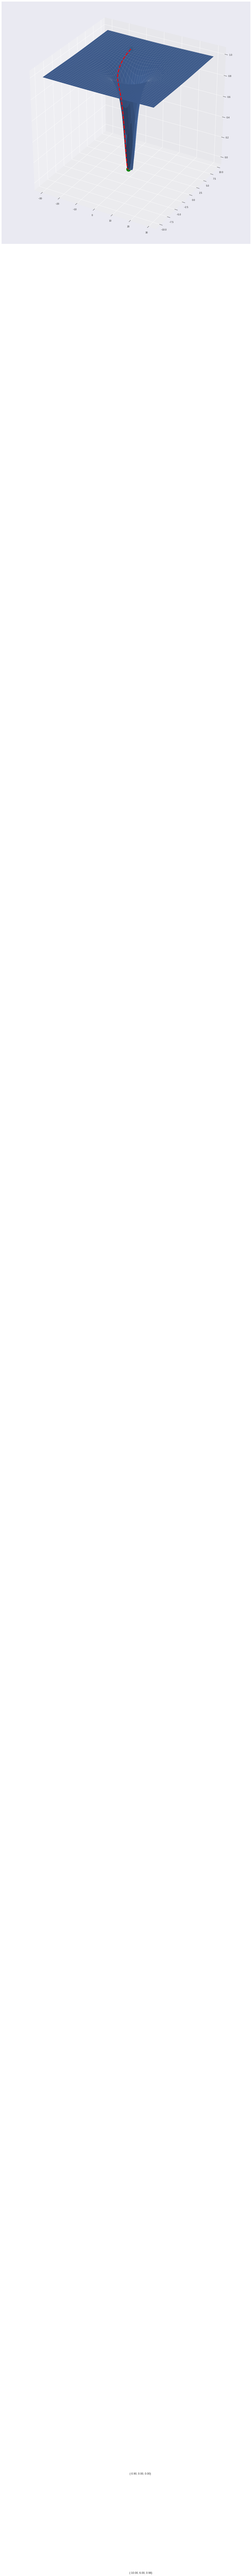

In [19]:
tf.reset_default_graph()

starting_val_x = tf.placeholder(tf.float32, shape=[])
starting_val_y = tf.placeholder(tf.float32, shape=[])
learning_rate = tf.placeholder(tf.float32)

x = tf.Variable(starting_val_x)
y = tf.Variable(starting_val_y)

# Equation:
num_steps = 1000
x_ini, y_ini = (-10.0, 6.0)
z_ini = func_7(x_ini, y_ini)
z = tf.exp(-1/(0.1*tf.square(x) +tf.square(y)))

x_vals = np.empty([num_steps])
y_vals = np.empty([num_steps])
z_vals = np.empty([num_steps])

train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(z)
init_op   = tf.global_variables_initializer()

with tf.Session() as sess:
  sess.run(init_op, feed_dict={starting_val_x:x_ini,starting_val_y:y_ini})
  for i in range(num_steps):
    x_vals[i] = x.eval()
    y_vals[i] = y.eval()
    z_vals[i] = z.eval()
    sess.run(train_op, feed_dict={learning_rate:0.9})
  plot_func(func_7)
        
tf.summary.FileWriter('logs', tf.get_default_graph()).close()

## Projeto - Regressão Linear 
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$
$\newcommand{\eqdef}{\equiv}$

### TEORIA

#### Problema da regressão linear

Seja o conjunto de treinamento:
$$
\Im  = \left\{ {({x_1},{y_1}),({x_2},{y_2}), \cdots ,({x_N},{y_N})} \right\}
$$

Supomos que: existe uma relação linear entre todo  $x$ e $y$, pode-se expressar essa relação em forma matricial como: 
$$ 
y= Xw
$$
Onde:
* $y$: o vetor que contem todos as respostas do conjunto de treinamento.
$$
y = \left[y_1,\cdots,y_i,\cdots,y_N\right]^T  \in \RR^{N \times 1}
$$
* $X \in \RR^{N \times p}$: é a matriz cujas linhas armazenam as observações $x_i \in \RR^p$.


Já que $N > p$, este é um sistema de **sobre-determinado**, que pode resolvido no sentido dos mínimos quadrados
$$ 
\umin{ w }  \norm{Xw-y}^2 
$$

Tal problema de otimização tem como **SOLUÇÃO FECHADA** a seguinte equação, que faz usso da [pseudo-inversa de Moore-Penrose](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse)
$$ 
w = (X^\top X)^{-1} X^\top y 
$$

### PRATICA

### Determinando o modelo de regressão de um conjunto de dados aleatorios

Usando `NumPy`, geramos 300 pontos aleatórios ao redor da equação $y = 0.22x + 0.78$:

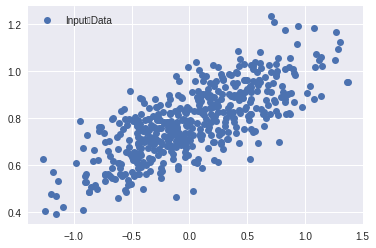

In [20]:
number_of_points = 500
x_point	=	[]
y_point	=	[]
a	=	0.22
b	=	0.78
for	i	in	range(number_of_points):
  x	=	np.random.normal(0.0,0.5)
  y	=	a*x	+	b	+np.random.normal(0.0,0.1)
  x_point.append([x])
  y_point.append([y])
  
  
plt.plot(x_point,y_point,	'o',	label='Input	Data')
plt.legend()
plt.show()

#### Exe. 1

Usando a  [pseudo-inversa de Moore-Penrose](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse)  determine o modelo linear de regressão do conjunto de dados 2D gerados inicialmente. Grafique a curva de regressão sobre o conjunto de dados.

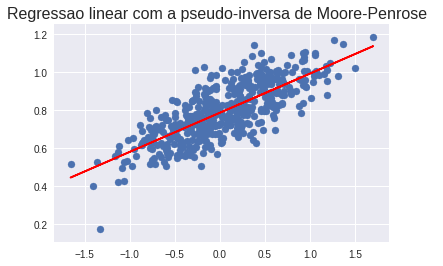

In [21]:
number_of_points = 500
x_point	=	np.zeros((number_of_points))
y_point	=	np.zeros((number_of_points))
a	=	0.22
b	=	0.78

for	i	in	range(number_of_points):
  point_x	=	np.random.normal(0.0,0.5)
  point_y	=	a*point_x +	b	+ np.random.normal(0.0,0.1)
  x_point[i] = point_x
  y_point[i] = point_y

x = x_point.reshape(len(x_point),1)
x = np.c_[ np.ones(len(x_point)),x_point]

# calculo de w
transposed_product = np.matmul(np.transpose(x),x)
inverse = np.linalg.inv(transposed_product)
transpose = np.matmul(inverse, np.transpose(x))
w = np.matmul(transpose,y_point)

function = w[1]*x_point + w[0]

# Regressao linear com a pseudo-inversa de Moore-Penrose  
plt.scatter(x_point,y_point)
plt.title("Regressao linear com a pseudo-inversa de Moore-Penrose  ", fontsize=16)
plt.plot(x_point, function, 'r')
plt.show()

#### Exe. 2

Usando SGD determine o modelo linear de regressão do conjunto de dados 2D gerados inicialmente. . Grafique a curva de regressão sobre o conjunto de dados.

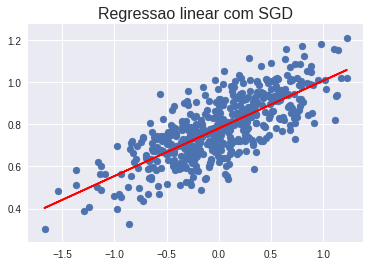

In [22]:
tf.reset_default_graph()

number_of_points = 500
x_point	=	np.zeros((number_of_points))
y_point	=	np.zeros((number_of_points))
a	=	0.22
b	=	0.78

for	i	in	range(number_of_points):
  point_x	=	np.random.normal(0.0,0.5)
  point_y	=	a*point_x + b + np.random.normal(0.0,0.1)
  x_point[i] = point_x
  y_point[i] = point_y

# Taxa de aprendizagem
learning_rate = 1.1

X = tf.placeholder("float")
Y = tf.placeholder("float")

# As variaveis que serão otimizadas
W1 = tf.Variable(np.random.randn(), name="weight")
W0 = tf.Variable(np.random.randn(), name="bias")

# y_pred = W0 + W1X
pred = tf.add(tf.multiply(X, W1), W0)

# MSE
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*number_of_points)

# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op  = optimizer.minimize(cost)

# Inicializar variáveis
init = tf.global_variables_initializer()

# Treino
with tf.Session() as sess:
  sess.run(init)
  for (x, y) in zip(x_point, y_point):
      sess.run(train_op, feed_dict={X:x_point, Y:y_point})

  function = sess.run(W1)*x_point + sess.run(W0)
  
plt.scatter(x_point,y_point)
plt.title("Regressao linear com SGD", fontsize=16)
plt.plot(x_point, function, 'r')
plt.show()

### Determinando o modelo de regressão sobre os dados do *Iris flower data set*

Usando `Sklearn`, cargamos o banco de dados [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set)

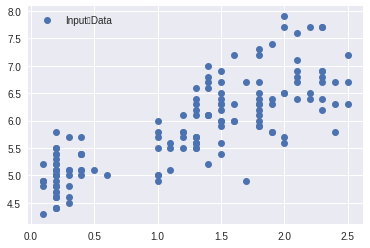

In [23]:
from sklearn import datasets

iris = datasets.load_iris()
x_point = np.array([x[3] for x in iris.data])
y_point = np.array([y[0] for y in iris.data])

plt.plot(x_point,y_point,	'o',	label='Input	Data')
plt.legend()
plt.show()

#### Exe. 1

Usando SGD determine o modelo linear de regressão do conjunto de dados 2D gerados apartir do *Iris flower data set*. 
* Os hiperparametros a usar para o GSD devem ser:
  * `learning_rate` = definido pelo usuario
  * `batch_size    = 25`
  *  `Epooch` = definido pelo usuario
* Grafique a curva de regressão sobre o conjunto de dados.

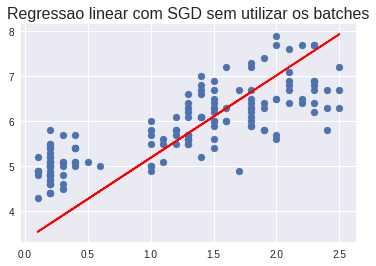

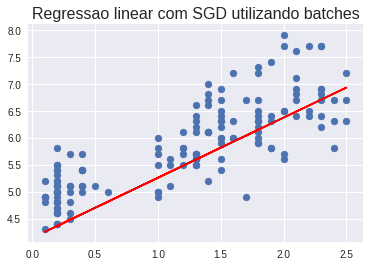

In [24]:
tf.reset_default_graph()

from sklearn import datasets
import random

iris = datasets.load_iris()
x_point = np.array([x[3] for x in iris.data])
y_point = np.array([y[0] for y in iris.data])

# Parâmetros
learning_rate = 0.1
epocas = 1000
batch = 25

X = tf.placeholder("float")
Y = tf.placeholder("float")

# As variaveis que serão otimizadas / Inicializadas randomicamente
W1 = tf.Variable(np.random.randn(), name="weight")
W0 = tf.Variable(np.random.randn(), name="bias")

# y_pred = W0 + W1X
pred = tf.add(tf.multiply(X, W1), W0)

# MSE
cost = tf.reduce_sum(tf.pow(pred-Y, 2))/(2*number_of_points)

# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op  = optimizer.minimize(cost)

# Inicializar variáveis
init = tf.global_variables_initializer()

# Treino
with tf.Session() as sess:
  sess.run(init)

  for (x, y) in zip(x_point, y_point):
      sess.run(train_op, feed_dict={X: x_point, Y:y_point})

  function = sess.run(W1)*x_point + sess.run(W0)
  
plt.scatter(x_point,y_point)
plt.title("Regressao linear com SGD sem utilizar os batches", fontsize=16)
plt.plot(x_point, function, 'r')
plt.show()

################################################################################
## Utilizando BATCHES

with tf.Session() as sess:
  sess.run(init)
  ramdom_x_point = np.copy(x_point)
  ramdom_y_point = np.copy(y_point)
  
  for e in range(0,epocas):
    random.shuffle(ramdom_x_point)
    random.shuffle(ramdom_y_point)
    sess.run(train_op, feed_dict={X:ramdom_x_point[0:batch], Y:ramdom_y_point[0:batch]})

  function = sess.run(W1)*x_point + sess.run(W0)
  
plt.scatter(x_point,y_point)
plt.title("Regressao linear com SGD utilizando batches", fontsize=16)
plt.plot(x_point, function, 'r')
plt.show()